In [1]:
DATE = "2021-08-24"
TASK = "assess-convergence-phage-1000x-coverage"
DIR = mkpath("$(homedir())/$(DATE)-$(TASK)")

"/home/jovyan/2021-08-24-assess-convergence-phage-1000x-coverage"

In [32]:
import Pkg
pkgs = [
#     "BioAlignments",
    "BioSequences",
    "Clustering",
#     "CodecZlib",
#     "Colors",
#     "Combinatorics",
#     "DataFrames",
#     "DataStructures",
    "Dates",
#     "DelimitedFiles",
#     "Distances",
#     "EzXML",
    "FASTX",
#     "GFF3",
#     "HTTP",
#     "Impute",
#     "JSON",
    "LightGraphs",
    "LSHFunctions",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
#     "NumericIO",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
    "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
    "Statistics",
    "StatsBase",
    "StatsPlots",
#     "StringDistances",
#     "uCSV",
#     "XLSX",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

In [3]:
if Sys.isapple()
    BANDAGE = "/Applications/Bandage.app/Contents/MacOS/Bandage"
else
    BANDAGE = "Bandage"
end

"Bandage"

In [4]:
function assess_kmer_sparsity_in_reads(k, observations)
#     @show k, observations
    canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations)
#     canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, first(observations))
# #     @show canonical_kmer_counts
#     for i in 2:length(observations)
#         canonical_kmer_counts_ = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations[i])
#         canonical_kmer_counts = merge!(+, canonical_kmer_counts, canonical_kmer_counts_)
#     end
#     canonical_kmer_counts = map(o -> Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, o), observations)...)
    total_observed_canonical_kmers = length(keys(canonical_kmer_counts))
    total_possible_canonical_kmers = (4^k)/2
    sparsity = round(total_observed_canonical_kmers/total_possible_canonical_kmers*100, sigdigits=3)
    @show sparsity
    return sparsity
end

assess_kmer_sparsity_in_reads (generic function with 1 method)

In [5]:
function sequence_to_canonical_kmers(kmer_type, sequence)
    return (BioSequences.canonical(kmer.fw) for kmer in BioSequences.each(kmer_type, sequence))
end

sequence_to_canonical_kmers (generic function with 1 method)

In [6]:
function determine_edge_weights(graph)
    outgoing_edge_probabilities = determine_edge_weights(graph, true)
    incoming_edge_probabilities = determine_edge_weights(graph, false)
    return Dict(true => outgoing_edge_probabilities, false => incoming_edge_probabilities)
end

determine_edge_weights (generic function with 1 method)

In [7]:
function determine_edge_weights(graph, strand)
    kmers = [graph.vprops[v][:kmer] for v in LightGraphs.vertices(graph)]
    outgoing_edge_weights = SparseArrays.spzeros(length(kmers), length(kmers))
    
    for (kmer_index, kmer) in enumerate(kmers)
        if !strand
            kmer = BioSequences.reverse_complement(kmer)
        end
        
        downstream_neighbors = []
        downstream_neighbor_weights = []
        for neighbor in BioSequences.neighbors(kmer)
            canonical_neighbor = BioSequences.canonical(neighbor)
            neighbor_orientation = neighbor == canonical_neighbor
            
            neighbor_index_range = searchsorted(kmers, canonical_neighbor)
            if !isempty(neighbor_index_range)
                @assert length(neighbor_index_range) == 1
                neighbor_index = first(neighbor_index_range)
                if LightGraphs.has_edge(graph, LightGraphs.Edge(kmer_index, neighbor_index))
                    edge_orientations = graph.eprops[LightGraphs.Edge(kmer_index, neighbor_index)][:orientations]
                    this_edge_orientation = (source_orientation = strand, destination_orientation = neighbor_orientation)
                    if this_edge_orientation in edge_orientations
                        edge_weight = graph.eprops[LightGraphs.Edge(kmer_index, neighbor_index)][:weight]
                        outgoing_edge_weights[kmer_index, neighbor_index] = edge_weight
                    end
                end
            end
        end
    end
    return outgoing_edge_weights
end

determine_edge_weights (generic function with 2 methods)

In [8]:
function determine_edge_probabilities(edge_weights)
    edge_probabilities = deepcopy(edge_weights)
    for orientation in [true, false]
        for row in 1:size(edge_probabilities[orientation], 1)
            edge_weights = edge_probabilities[orientation][row, :]
            edge_total = sum(edge_weights)
            for (col, edge_weight) in enumerate(edge_weights)
                if edge_total > 0
                    edge_probabilities[orientation][row, col] = edge_weight/edge_total
                else
                    edge_probabilities[orientation][row, col] = 0.0
                end
            end
        end
    end
    return edge_probabilities
end

determine_edge_probabilities (generic function with 1 method)

In [9]:
function random_step(current_vertex, current_orientation, step_probabilities)
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][current_vertex, :]
    chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
    possible_orientations = observation_graph.eprops[LightGraphs.Edge(current_vertex, chosen_step)][:orientations]
    possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
    chosen_orientation = rand(possible_orientations).destination_orientation
    chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
    return chosen_oriented_step
end

random_step (generic function with 1 method)

In [10]:
function random_walk(observation_graph, initial_vertex, initial_orientation, step_probabilities; n_steps=size(step_probabilities[true], 1))
    step_count = 0
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][initial_vertex, :]
    walk = Vector{NamedTuple{(:vertex, :orientation), Tuple{Int64, Bool}}}()
    done = (step_count > n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    current_vertex = initial_vertex
    current_orientation = initial_orientation
    while !done
#         @show "choosing"
        chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
        chosen_step
        possible_orientations = observation_graph.eprops[LightGraphs.Edge(current_vertex, chosen_step)][:orientations]
        possible_orientations
        current_orientation
        possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
        possible_orientations
        chosen_orientation = rand(possible_orientations).destination_orientation
        chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
        push!(walk, chosen_oriented_step)
        current_vertex = chosen_step
        current_orientation = chosen_orientation
        outgoing_edge_likelihoods = step_probabilities[last(walk).orientation][last(walk).vertex, :]
        step_count += 1
#         @show outgoing_edge_likelihoods
        done = (step_count > n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    end
    return walk
end

random_walk (generic function with 1 method)

In [11]:
# generate a genome
sequence_length = 1_000
sequence = BioSequences.randdnaseq(Random.seed!(sequence_length), sequence_length)
sequence_id = string(hash(sequence))
fasta_record = FASTX.FASTA.Record(sequence_id, sequence)

FASTX.FASTA.Record:
   identifier: 3905072901333009698
  description: <missing>
     sequence: GGCGCGTGCTAGCGGTGTGGTTCTACATTGTATTGTATT…

In [12]:
reference_fasta_file = "$(DIR)/LENGTH-$(sequence_length).fasta"
open(reference_fasta_file, "w") do io
    fastx_io = FASTX.FASTA.Writer(io)
    write(fastx_io, fasta_record)
    close(fastx_io)
end

In [13]:
# randomly sample reads with errors from the genome
error_rate = 0.01
n_reads = 100

# observations = [Mycelia.observe(FASTX.sequence(record), error_rate = error_rate) for i in 1:n_reads]
observations = [Mycelia.observe(fasta_record, error_rate = error_rate) for i in 1:n_reads];

In [14]:
# determine distribution of read lengths

In [15]:
median_read_length = Statistics.median(length.(FASTX.sequence.(observations)))
std_deviation_read_length = Statistics.std(length.(FASTX.sequence.(observations)))
captures_99_percent_of_reads = Int(floor(median_read_length - 4*std_deviation_read_length))

990

In [16]:
# determine optimal k
min_k = min(13, captures_99_percent_of_reads)
max_k = min(61, captures_99_percent_of_reads)
k_options = Primes.primes(min_k, max_k)
k_index = findfirst(k -> assess_kmer_sparsity_in_reads(k, observations) < .01, k_options)
k = k_options[k_index]
@show k

sparsity = 0.0318
sparsity = 0.00016
k = 17


17

In [17]:
observations_file = "$(DIR)/LENGTH-$(sequence_length)-DEPTH-$(n_reads).fastq"
open(observations_file, "w") do io
    fastq_io = FASTX.FASTQ.Writer(io)
    for record in observations
        write(fastq_io, record)
    end
    close(fastq_io)
end

# Begin graph resolving of observation graph

In [ ]:
# assess kmer counts

In [ ]:
# fit linear trendline to kmer counts

In [ ]:
# apply thresholding when constructing kmer graph at the trendline

In [21]:
kmer_counts_histogram = sort(collect(StatsBase.countmap(values(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations_file)))), by=x->x[1])

25-element Vector{Pair{Int64, Int64}}:
  1 => 11574
  2 => 1019
  3 => 118
  4 => 2
  5 => 12
 75 => 2
 76 => 5
 77 => 16
 78 => 19
 79 => 19
 80 => 29
 81 => 43
 82 => 45
 83 => 71
 84 => 92
 85 => 95
 86 => 102
 87 => 115
 88 => 81
 89 => 93
 90 => 67
 91 => 48
 92 => 26
 93 => 12
 94 => 4

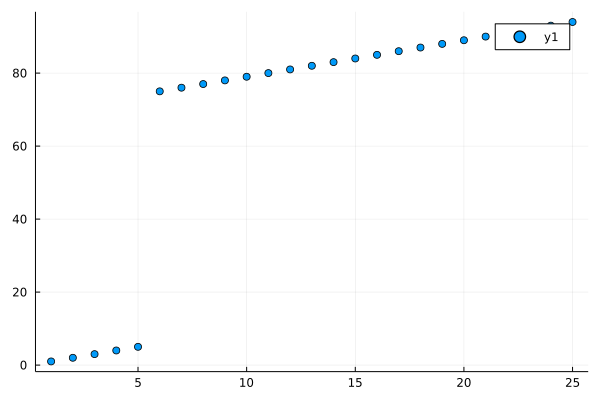

In [28]:
StatsPlots.scatter(first.(kmer_counts_histogram))

In [29]:
kmer_depth_of_coverage_bins = first.(kmer_counts_histogram)

25-element Vector{Int64}:
  1
  2
  3
  4
  5
 75
 76
 77
 78
 79
 80
 81
 82
 83
 84
 85
 86
 87
 88
 89
 90
 91
 92
 93
 94

In [31]:
distance_matrix = zeros(Int, (length(kmer_depth_of_coverage_bins), length(kmer_depth_of_coverage_bins)))
for (row, depth_of_coverage_bin_1) in enumerate(kmer_depth_of_coverage_bins)
    for (col, depth_of_coverage_bin_2) in enumerate(kmer_depth_of_coverage_bins)
        distance = abs(depth_of_coverage_bin_1 - depth_of_coverage_bin_2)
        distance_matrix[row, col] = distance
    end
end
distance_matrix

25×25 Matrix{Int64}:
  0   1   2   3   4  74  75  76  77  …  85  86  87  88  89  90  91  92  93
  1   0   1   2   3  73  74  75  76     84  85  86  87  88  89  90  91  92
  2   1   0   1   2  72  73  74  75     83  84  85  86  87  88  89  90  91
  3   2   1   0   1  71  72  73  74     82  83  84  85  86  87  88  89  90
  4   3   2   1   0  70  71  72  73     81  82  83  84  85  86  87  88  89
 74  73  72  71  70   0   1   2   3  …  11  12  13  14  15  16  17  18  19
 75  74  73  72  71   1   0   1   2     10  11  12  13  14  15  16  17  18
 76  75  74  73  72   2   1   0   1      9  10  11  12  13  14  15  16  17
 77  76  75  74  73   3   2   1   0      8   9  10  11  12  13  14  15  16
 78  77  76  75  74   4   3   2   1      7   8   9  10  11  12  13  14  15
 79  78  77  76  75   5   4   3   2  …   6   7   8   9  10  11  12  13  14
 80  79  78  77  76   6   5   4   3      5   6   7   8   9  10  11  12  13
 81  80  79  78  77   7   6   5   4      4   5   6   7   8   9  10  11  12
 82 

In [ ]:
results_table = DataFrames.DataFrame(k = Int[], model = )

In [33]:
typeof(Clustering.kmedoids(distance_matrix, 1))

Clustering.KmedoidsResult{Int64}

In [ ]:
k1_result = 

In [18]:
# make me faster by counting edges ahead of time
observation_graph = Mycelia.fastx_to_simple_kmer_graph(BioSequences.DNAMer{k}, observations_file)

┌ Info: counting kmers
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2999
┌ Info: setting metadata on vertices
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:3007
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
┌ Info: loading fastx files into graph
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:3016
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


{13709, 28906} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [ ]:
kmer_counts = Dict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [ ]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

In [ ]:
kmer_counts_histogram = sort(collect(StatsBase.countmap(collect(values(kmer_counts)))), by=x->x[1])

In [ ]:
# earliest_y_min_index = last(findmin(last.(kmer_counts_histogram)))

In [ ]:
# lower_boundary

In [ ]:
# lower_boundary = first(kmer_counts_histogram[43])
# lower_boundary_source = "first minimum"

In [ ]:


#     try
#         # take the first 1/denominator datapoints in the set
#         # to capture the error line on the left side of the graph
#         @info "fitting error curve"
#         denominators = [2^i for i in 1:5]
#         coeficient_matrix = zeros(length(denominators), 2)
#         for (i, denominator) in enumerate(denominators)
#             prefix_index = Int(floor(length(X)/denominator))
#             _x = X[1:prefix_index]
#             _y = Y[1:prefix_index]
#             model = GLM.lm(GLM.@formula(Y ~ X), DataFrames.DataFrame(X = _x, Y = _y))
#             coeficient_matrix[i, :] = GLM.coef(model)
#         end
#         median_intercept = Statistics.median(coeficient_matrix[:, 1])
#         median_slope = Statistics.median(coeficient_matrix[:, 2])

#         X_intercept = (0 - median_intercept) / median_slope

#         # some libraries detect the x_intercept being AFTER the end of the data
#         # in these instances detect the earliest x-minimum
#         if X_intercept < lower_boundary
#             lower_boundary = X_intercept
#             lower_boundary_source = "detected x-intercept"
#         end
#     catch
#         @info "unable to fit regression"
#     end

#     p = StatsPlots.vline!(p,
#         [lower_boundary],
#         label="lower boundary ($(lower_boundary_source))"
#     );
    
#     is_above_lower_bounds = X .>= lower_boundary
#     max_Y_post_error_intercept = first(findmax(Y[is_above_lower_bounds]))
#     peak_indices = findall(is_above_lower_bounds .& (Y .== max_Y_post_error_intercept))
#     peak_index = Int(round(Statistics.median(peak_indices)))

#     p = StatsPlots.vline!([X[peak_index]], label="inferred sample coverage)")
#     if isinteractive()
#         display(p)
#     end
#     StatsPlots.savefig(p, "$jf_file.peak-detected.png")
#     StatsPlots.savefig(p, "$jf_file.peak-detected.svg")
    
#     if target_coverage != 0
#         detected_coverage = 2^(X[peak_index])
#         downsampling_rate = round(target_coverage/detected_coverage, sigdigits=3)
#         downsampling_rate = min(downsampling_rate, 1)
#         @info "downsampling rate = $downsampling_rate"

#         outfile = "$kmer_directory/downsampling-rate.txt"
#         open(outfile, "w") do io
#             @info "writing downsampling rate to $outfile"
#             println(io, downsampling_rate)
#         end
#         return downsampling_rate
#     end

In [ ]:
# function analyze_kmer_spectra(;kmer_directory, forward_reads, reverse_reads, k=17, target_coverage=0)
#     @info "counting $k-mers"
#     @info "determining max count"
#     p = pipeline(
#         `jellyfish dump -ct $jf_file`,
#         `awk '{print $2}'`,
#         `sort --numeric-sort --reverse`,
#         `head -n1`)
#     max_count = parse(Int, read(p, String))
#     @info "max count = $max_count"

#     @info "generating histogram"
#     histogram_matrix = Int.(DelimitedFiles.readdlm(open(`jellyfish histo --high $max_count $jf_file`)))

#     X = log2.(histogram_matrix[:, 1])
#     Y = log2.(histogram_matrix[:, 2])
    
#     @info "plotting kmer spectra"
#     p = StatsPlots.scatter(
#         X,
#         Y,
#         xlabel="log2(kmer_frequency)",
#         ylabel="log2(# of kmers @ frequency)",
#         label=""
#     )


# end



In [ ]:
# step 1, hard-filter singletons

In [ ]:
filtered_vertices = findall(v -> observation_graph.vprops[v][:weight] >= 5, LightGraphs.vertices(observation_graph))

In [ ]:
filtered_observation_graph, vertex_map = LightGraphs.induced_subgraph(observation_graph, filtered_vertices)

In [ ]:
# # visualize
# gfa_file = observations_file * ".k-$k.filtered.gfa"
# Mycelia.graph_to_gfa(filtered_observation_graph, gfa_file)

# run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# # --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# # --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# # --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

# html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
# html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

# x = "<img src=$(html_path_to_svg)>"
# display("text/html", x)
# # display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
kmer_counts = Dict(filtered_observation_graph.vprops[v][:kmer] => filtered_observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(filtered_observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [ ]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

In [ ]:
# step 2, re-simulate reads as a means of error correction

In [ ]:
kmers = [filtered_observation_graph.vprops[v][:kmer] for v in LightGraphs.vertices(filtered_observation_graph)]
kmer_weights = [filtered_observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(filtered_observation_graph)]
kmer_probabilities = kmer_weights ./ sum(kmer_weights)

In [ ]:
edge_weights = determine_edge_weights(filtered_observation_graph)

In [ ]:
edge_weights[true]

In [ ]:
@time edge_weights = determine_edge_weights(filtered_observation_graph)
@time edge_probabilities = determine_edge_probabilities(edge_weights)

In [ ]:
kmers = [filtered_observation_graph.vprops[v][:kmer] for v in LightGraphs.vertices(filtered_observation_graph)]
kmer_weights = [filtered_observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(filtered_observation_graph)]
kmer_probabilities = kmer_weights ./ sum(kmer_weights)

edge_weights = determine_edge_weights(filtered_observation_graph)
edge_probabilities = determine_edge_probabilities(edge_weights)

step_probabilities = deepcopy(edge_probabilities)

for orientation in [true, false]
#     @show orientation
    oriented_step_probabilities = step_probabilities[orientation] 
    for row in 1:size(step_probabilities[orientation], 1)
        step_probabilities_ = step_probabilities[orientation][row, :] .* kmer_probabilities
        if sum(step_probabilities_) > 0
            step_probabilities[orientation][row, :] .= step_probabilities_ ./ sum(step_probabilities_)
        end
    end
end

In [ ]:
new_records = FASTX.FASTQ.Record[]
ProgressMeter.@showprogress for observation in observations
    read_length = length(FASTX.sequence(observation))
    max_steps = read_length - filtered_observation_graph.gprops[:k]
    # apply a squaring penalty to kmer_weights?
    initial_vertex = StatsBase.sample(1:length(kmers), StatsBase.weights(kmer_weights.^2))
#     @show "choosing initial vertex $initial_vertex with probability $(kmer_weights[initial_vertex])"
    initial_orientation = rand(Bool)
    forward_walk = random_walk(filtered_observation_graph, initial_vertex, initial_orientation, step_probabilities, n_steps=max_steps)
    remaining_steps = max_steps - length(forward_walk)
    reverse_walk = random_walk(filtered_observation_graph, initial_vertex, !initial_orientation, step_probabilities, n_steps = remaining_steps)
    full_walk = [[(vertex=x.vertex, orientation=!x.orientation) for x in reverse(reverse_walk)]..., [(vertex = initial_vertex, orientation = initial_orientation)]..., forward_walk...]
    oriented_path = [(x.vertex, x.orientation) for x in full_walk]
    new_seq = Mycelia.oriented_path_to_sequence(filtered_observation_graph, oriented_path)
    new_record = FASTX.FASTQ.Record(
        FASTX.identifier(observation)*"-k$k",
        FASTX.identifier(observation),
        new_seq,
        StatsBase.sample(FASTX.quality(observation), length(new_seq))
    )
#     @show "here"
    push!(new_records, new_record)
end
new_records;

In [ ]:
corrected_fastq_file = replace(observations_file, r"\.fastq" => ".k$k.fastq")
open(corrected_fastq_file, "w") do io
    fastq_writer = FASTX.FASTQ.Writer(io)
    for record in new_records
        write(fastq_writer, record)
    end
    close(fastq_writer)
end

In [ ]:
corrected_observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, corrected_fastq_file)

In [ ]:
# visualize
gfa_file = corrected_fastq_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(corrected_observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
kmer_counts = Dict(corrected_observation_graph.vprops[v][:kmer] => corrected_observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(corrected_observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [ ]:
# compare the new graph to the error-free graph to the error-corrected graph

In [ ]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

# Final polish and reduction

In [ ]:
# to_filter = Int[]
connected_component = first(LightGraphs.connected_components(corrected_observation_graph))

In [ ]:
tip_vertices = filter(v -> LightGraphs.degree(corrected_observation_graph, v) == 2, LightGraphs.vertices(corrected_observation_graph))

In [ ]:
if length(tip_vertices) > 2
    component_weights = map(v -> corrected_observation_graph.vprops[v][:weight], connected_component)
    component_median = Statistics.median(component_weights)
    component_standard_deviation = Statistics.std(component_weights)
    tips_to_drop = filter(tip -> corrected_observation_graph.vprops[tip][:weight] < component_median - 2*component_standard_deviation, tip_vertices) 
    polished_graph, vertex_map = LightGraphs.induced_subgraph(corrected_observation_graph, setdiff(LightGraphs.vertices(corrected_observation_graph), tips_to_drop))
    simplified_graph = Mycelia.simplify_kmer_graph(polished_graph)
else
    simplified_graph = Mycelia.simplify_kmer_graph(corrected_observation_graph)
end

In [ ]:
# write simplified graph to gfa
# visualize
gfa_file = corrected_fastq_file * ".k-$k.simplified.gfa"
Mycelia.graph_to_gfa(simplified_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
simplified_graph.vprops[1][:weight]

In [ ]:
Mycelia.is_equivalent(FASTX.sequence(fasta_record), simplified_graph.vprops[1][:sequence])

# THE SAME!!!

In [ ]:
# write contigs to fasta
final_fasta_file = corrected_fastq_file * ".k-$k.simplified.fasta"
open(final_fasta_file, "w") do io
    fasta_io = FASTX.FASTA.Writer(io)
    for vertex in LightGraphs.vertices(simplified_graph)
        seq = simplified_graph.vprops[vertex][:sequence]
        description = string(simplified_graph.vprops[vertex][:weight])
        id = string(hash(seq)) * '-' * string(Dates.now())
        record = FASTX.FASTA.Record(id, description, seq)
        @show record
        write(fasta_io, record)
    end
    close(fasta_io)
end